## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

from nltk.stem.porter import *
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

import warnings
warnings.filterwarnings('ignore')

## Data

In [2]:
df_cfb = pd.read_csv('../datasets/subreddit_cfb', usecols = ['title', 'subreddit', 'selftext'])
print(df_cfb.shape)
df_cfb.head()

(2500, 3)


,selftext,subreddit,title
0,I have seen several times during all the re-al...,CFB,How do research budgets impact conferences?
1,[removed],CFB,Is there a chance Pac12 can just kick out WSU?...
2,NaN,CFB,[Sam Block] - The last time Michigan beat Ohio...
3,[removed],CFB,Rename the Big Ten (which has 14 members) and ...
4,NaN,CFB,"Nick Saban on Jahleel Billingsley, team: “This..."


In [3]:
df_bball = pd.read_csv('../datasets/subreddit_cbball', usecols = ['title', 'subreddit', 'selftext'])
print(df_bball.shape)
df_bball.head()

(2500, 3)


,selftext,subreddit,title
0,***The Massachusetts Showdown***\n\nIn this se...,CollegeBasketball,The Intra-State Showdown: Massachusetts
1,"***The Maryland Showdown***\n\nIn this series,...",CollegeBasketball,The Intra-State Showdown: Maryland
2,***The Louisiana Showdown***\n\nIn this series...,CollegeBasketball,The Intra-State Showdown: Louisiana
3,"B10 has 14 members, B12 has 8. The other power...",CollegeBasketball,Rename the Big Ten and Big 12
4,NaN,CollegeBasketball,2020 NBA Mock Draft (First Round)


In [4]:
df = pd.concat([df_cfb, df_bball])
print(df.shape)
df.head()

(5000, 3)


,selftext,subreddit,title
0,I have seen several times during all the re-al...,CFB,How do research budgets impact conferences?
1,[removed],CFB,Is there a chance Pac12 can just kick out WSU?...
2,NaN,CFB,[Sam Block] - The last time Michigan beat Ohio...
3,[removed],CFB,Rename the Big Ten (which has 14 members) and ...
4,NaN,CFB,"Nick Saban on Jahleel Billingsley, team: “This..."


## Data Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 2499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   selftext   2362 non-null   object
 1   subreddit  5000 non-null   object
 2   title      4999 non-null   object
dtypes: object(3)
memory usage: 156.2+ KB


### Binarize Subreddits 1: CFB, 0: CollegeBasketball

In [6]:
# College Football is 1 and College Basketball is 0
df['subreddit'] = df['subreddit'].map({'CFB': 1, 'CollegeBasketball': 0})

### Check for nulls and add post_length, post_word_count

In [7]:
df['selftext'].replace('[removed]', np.NaN, inplace = True)
df['selftext'].replace('[deleted]', np.NaN, inplace = True)

In [8]:
df.dropna(inplace = True)
print(df.shape)

(1648, 3)


In [9]:
df['post'] = df['title'] + ' ' + df['selftext']
df['post_length'] = df['post'].str.len()
df['post_word_count'] = df['post'].str.count(' ') + 1

### Clean Text

In [10]:
df['post'] = df['post'].apply(lambda x: re.sub(r'http\S+', '', x))

for i, text in enumerate(df['post']):
    text_cleaned = text.replace('&amp;', '&')
    text_cleaned = text_cleaned.replace('nbsp;', ' ')
    text_cleaned = text_cleaned.replace("'\'", '')
    text_cleaned = text_cleaned.replace('-', '')
    text_cleaned = text_cleaned.replace('/', ' ')
    text_cleaned = text_cleaned.replace('&amp;#x200B;', '')
    text_cleaned = text_cleaned.replace('&#x200B;', '')
    df['post'].iloc[i] = text_cleaned.replace('\n', ' ').strip()
    
# https://stackoverflow.com/questions/20894525/how-to-remove-parentheses-and-all-data-within-using-pandas-python

### Outliers

In [11]:
df.describe()

,subreddit,post_length,post_word_count
count,1648.000000,1648.000000,1648.000000
mean,0.582524,785.037015,112.510316
std,0.493292,1753.832994,265.319255
min,0.000000,18.000000,2.000000
25%,0.000000,179.750000,17.000000
50%,1.000000,293.000000,36.000000
75%,1.000000,602.250000,96.000000
max,1.000000,35815.000000,5118.000000


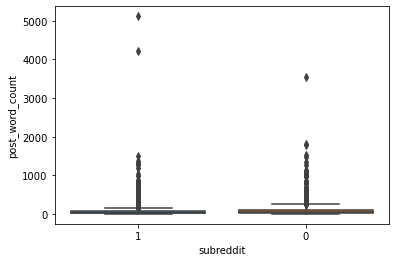

In [12]:
sns.boxplot(x = df['subreddit'], y = df['post_word_count'], 
            data = df, order = {1: 'CFB', 0: 'CollegeBasketball'});

In [13]:
q1_cfb = (df['post_word_count'][df['subreddit'] == 1]).quantile(.25)
q3_cfb = (df['post_word_count'][df['subreddit'] == 1]).quantile(.75)
IQR_cfb = q3_cfb - q1_cfb

outliers_cfb = q3_cfb + 1.5 * IQR_cfb
print('CFB outliers:', outliers_cfb)

q1_bball = (df['post_word_count'][df['subreddit'] == 0]).quantile(.25)
q3_bball = (df['post_word_count'][df['subreddit'] == 0]).quantile(.75)
IQR_bball = q3_bball - q1_bball

outliers_bball = q3_bball + 1.5 * IQR_bball
print('CollegeBasketball outliers:', outliers_bball)

df_cfb = df.loc[(df['subreddit'] == 1) & (df['post_word_count'] < outliers_cfb)]
df_bball = df.loc[(df['subreddit'] == 0) & (df['post_word_count'] < outliers_bball)]

CFB outliers: 162.5
CollegeBasketball outliers: 258.5


In [14]:
df = pd.concat([df_cfb, df_bball])
print(df.shape)

(1421, 6)


## EDA

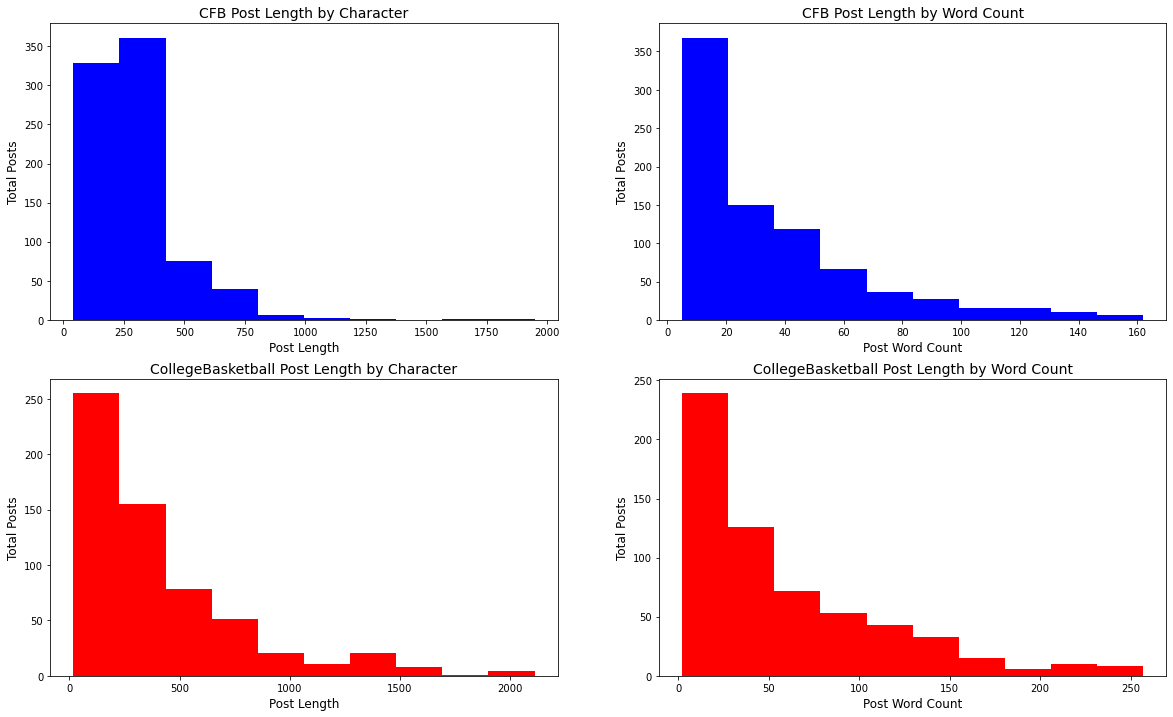

In [15]:
fig, ax = plt.subplots(2, 2, figsize = (20, 12))

ax[0][0].hist(df['post_length'][df['subreddit'] == 1], color = 'blue')
ax[0][0].set_xlabel('Post Length', fontsize = 12)
ax[0][0].set_ylabel('Total Posts', fontsize = 12)
ax[0][0].set_title('CFB Post Length by Character', fontsize = 14)

ax[0][1].hist(df['post_word_count'][df['subreddit'] == 1], color = 'blue')
ax[0][1].set_xlabel('Post Word Count', fontsize = 12)
ax[0][1].set_ylabel('Total Posts', fontsize = 12)
ax[0][1].set_title('CFB Post Length by Word Count', fontsize = 14)

ax[1][0].hist(df['post_length'][df['subreddit'] == 0], color = 'red')
ax[1][0].set_xlabel('Post Length', fontsize = 12)
ax[1][0].set_ylabel('Total Posts', fontsize = 12)
ax[1][0].set_title('CollegeBasketball Post Length by Character', fontsize = 14)

ax[1][1].hist(df['post_word_count'][df['subreddit'] == 0], color = 'red')
ax[1][1].set_xlabel('Post Word Count', fontsize = 12)
ax[1][1].set_ylabel('Total Posts', fontsize = 12)
ax[1][1].set_title('CollegeBasketball Post Length by Word Count', fontsize = 14);

### Stemming

In [16]:
stemmer = PorterStemmer()
df['stemmed_post'] = df['post'].apply(lambda x: ' '.join([stemmer.stem(w) for w in word_tokenize(x)]))

### Export Dataset

In [17]:
df.to_csv('../datasets/cfb_cbball', index = False)

### EDA on Word Counts

In [18]:
cvec = CountVectorizer(stop_words = 'english')

cfb_cvec = cvec.fit(df['post'][df['subreddit'] == 1])
bball_cvec = cvec.fit(df['post'][df['subreddit'] == 0])

trans_cfb = cvec.transform(df['post'][df['subreddit'] == 1]).todense()
trans_bball = cvec.transform(df['post'][df['subreddit'] == 0]).todense()

df_cfb_cvec = pd.DataFrame(cvec.transform(df['post'][df['subreddit'] == 1]).todense(),
                           columns = cfb_cvec.get_feature_names())
df_bball_cvec = pd.DataFrame(cvec.transform(df['post'][df['subreddit'] == 0]).todense(),
                             columns = bball_cvec.get_feature_names())

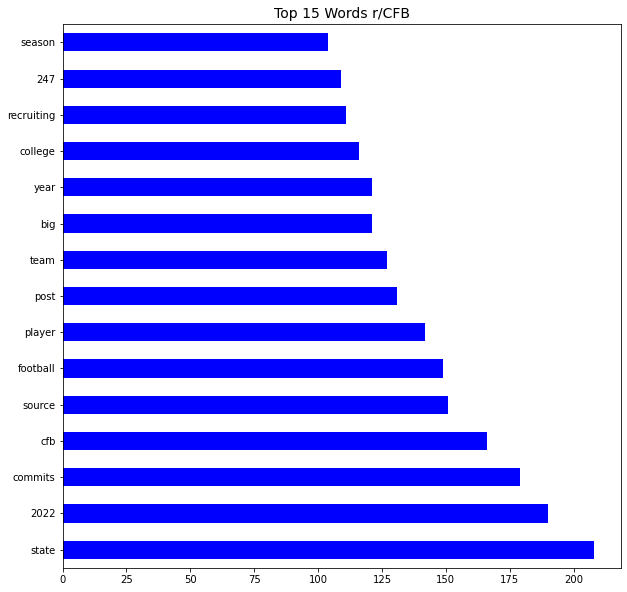

In [19]:
cfb_15 = df_cfb_cvec.sum().sort_values(ascending = False).head(15)
fig, ax = plt.subplots(figsize = (10, 10))
cfb_15.plot(kind = 'barh', color = 'blue')
ax.set_title('Top 15 Words r/CFB', fontsize = 14);

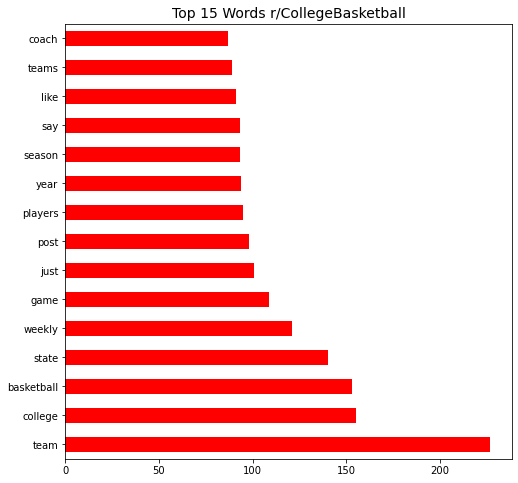

In [20]:
bball_15 = df_bball_cvec.sum().sort_values(ascending = False).head(15)
fig, ax = plt.subplots(figsize = (8, 8))
bball_15.plot(kind = 'barh', color = 'red')
ax.set_title('Top 15 Words r/CollegeBasketball', fontsize = 14);

In [21]:
tvec = TfidfVectorizer(stop_words = 'english',
                       strip_accents = 'ascii',
                       min_df = .1,)


cfb_tvec = tvec.fit(df['stemmed_post'][df['subreddit'] == 1])
bball_tvec = tvec.fit(df['stemmed_post'][df['subreddit'] == 0])

trans_cfb = tvec.transform(df['stemmed_post'][df['subreddit'] == 1]).todense()
trans_bball = tvec.transform(df['stemmed_post'][df['subreddit'] == 0]).todense()

df_cfb_tvec_stemmed = pd.DataFrame(tvec.transform(df['stemmed_post'][df['subreddit'] == 1]).todense(),
                                   columns = cfb_tvec.get_feature_names())
df_bball_tvec_stemmed = pd.DataFrame(tvec.transform(df['stemmed_post'][df['subreddit'] == 0]).todense(),
                                     columns = bball_tvec.get_feature_names())

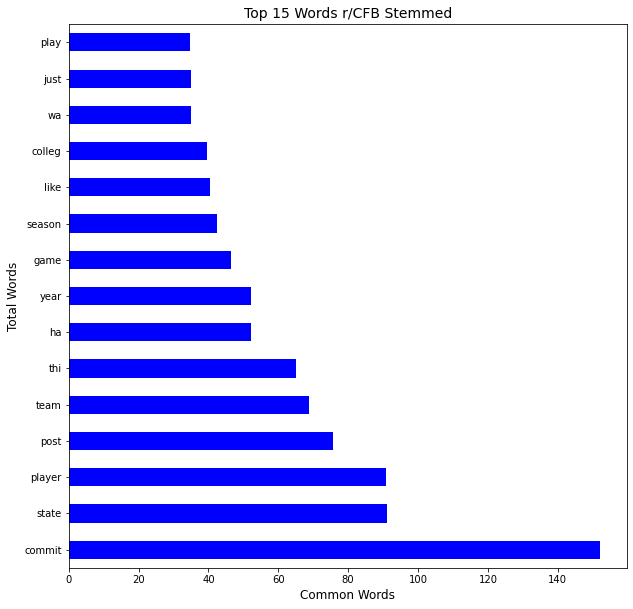

In [22]:
cfb_stemmed_25 = df_cfb_tvec_stemmed.sum().sort_values(ascending = False).head(15)
fig, ax = plt.subplots(figsize = (10, 10))
cfb_stemmed_25.plot(kind = 'barh', color = 'blue')
ax.set_xlabel('Common Words', fontsize = 12)
ax.set_ylabel('Total Words', fontsize = 12)
ax.set_title('Top 15 Words r/CFB Stemmed', fontsize = 14);

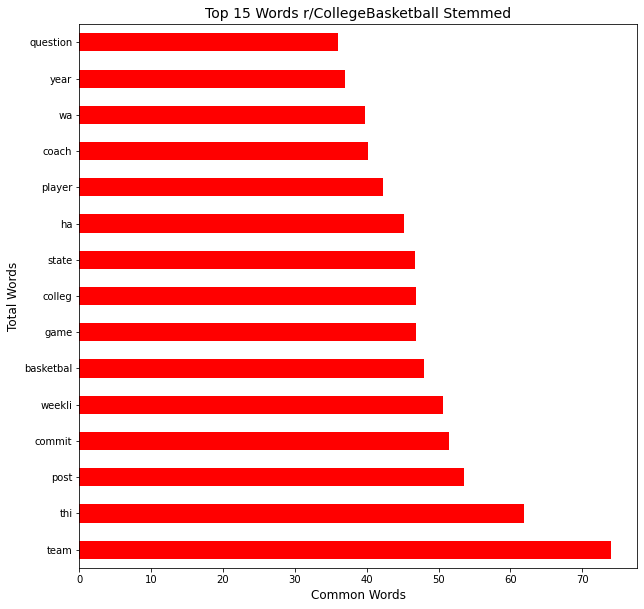

In [23]:
bball_stemmed_25 = df_bball_tvec_stemmed.sum().sort_values(ascending = False).head(15)
fig, ax = plt.subplots(figsize = (10, 10))
bball_stemmed_25.plot(kind = 'barh', color = 'red')
ax.set_xlabel('Common Words', fontsize = 12)
ax.set_ylabel('Total Words', fontsize = 12)
ax.set_title('Top 15 Words r/CollegeBasketball Stemmed', fontsize = 14);

In [24]:
nlp = spacy.load('en_core_web_sm')

nlp.add_pipe('spacytextblob')

cfb_text = (df['stemmed_post'][df['subreddit'] == 1]).to_string()
bball_text = (df['stemmed_post'][df['subreddit'] == 0]).to_string()

doc_cfb = nlp(cfb_text)
doc_bball = nlp(bball_text)

print('CFB Polarity:', doc_cfb._.polarity)
print('CFB Subjectivity:', doc_cfb._.subjectivity)

# subjectivity
print('CollegeBasketball Polarity:', doc_bball._.polarity)
print('CollegeBasketball Subjectivity:', doc_bball._.subjectivity)

CFB Polarity: 0.06879804651208767
CFB Subjectivity: 0.4241496792781037
CollegeBasketball Polarity: 0.1222440153525197
CollegeBasketball Subjectivity: 0.48171778531016124
